##**Методы машинного обучения для оценки содержания азота в растениях по аэрофотоснимкам**

Этот блокнот предназначен для генерации обучающих данных. Папка dataset содержит сырые изображения, необходимо конвертировать их в numpy-массив для более удобной загрузки данных. Также в этом блокноте при помощи простого алгоритма создаются синтетические изображения, которые также конвертируются в numpy-массивы. Таким образом, в дальнейшем в файлах с обучением моделей достаточно просто обратно подгрузить эти данные.

**Подключение данных из гитхаб-репозитория (уже не нужно)**

In [ ]:
# !git clone https://github.com/villerbond/nytrogen-status-analysis

Cloning into 'nytrogen-status-analysis'...
remote: Enumerating objects: 658, done.
remote: Counting objects: 100% (658/658), done.
remote: Compressing objects: 100% (655/655), done.
remote: Total 658 (delta 64), reused 553 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (658/658), 18.44 MiB | 8.79 MiB/s, done.
Resolving deltas: 100% (64/64), done.


**Подключение гугл-диска, чтобы загрузить туда данные в виде сжатых numpy-массивов (и исходные, и синтетические)**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Подключение всех необходимых библиотек**

In [2]:
import os
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import numpy as np

**Создание массивов путей до изображений**

In [3]:
dataset_dir = '/content/drive/MyDrive/VKR/dataset/my_dataset/dataset/'

In [4]:
train_dataset_dir = dataset_dir + '/train/'
test_dataset_dir = dataset_dir + '/test/'

In [5]:
def collect_data(root_dir):
    """
    Собирает пути к изображениям и маскам из указанной директории.

    Аргументы:
    root_dir - корневая папка, содержащая спектральные изображения и маски.

    Возвращает:
    images - список словарей, где ключи — спектральные каналы ('RGB', 'NDVI' и т. д.),
             а значения — пути к соответствующим изображениям
    masks - список путей к файлам масок.
    """
    images = []
    masks = []

    # Возможные альтернативные имена каналов
    spectrum_aliases = {
        "NDVI": ["NDVI"],
        "NIR": ["NearIR", "NIR"],
        "RedEdge": ["RedEdge"],
        "RGB": ["RGB"],
        "Red": ["Red"],
        "Green": ["Green"],
        "Blue": ["Blue"]
    }

    # Находим реальные пути к папкам
    spectra_paths = {}
    for key, aliases in spectrum_aliases.items():
        for alias in aliases:
            potential_path = os.path.join(root_dir, alias)
            if os.path.exists(potential_path):
                spectra_paths[key] = potential_path
                break
        else:
            print(f"⚠️ Папка для канала {key} не найдена (ожидались: {aliases})")

    # Папка с масками
    masks_dir = os.path.join(root_dir, "Mask")
    if not os.path.exists(masks_dir):
        print("⚠️ Папка с масками не найдена:", masks_dir)
        return images, masks  # Возвращаем пустые списки

    # Считываем список файлов
    mask_files = sorted(os.listdir(masks_dir))
    spectra_files = {
        spectrum: sorted(os.listdir(path))
        for spectrum, path in spectra_paths.items()
    }

    # Сбор данных
    for i, mask_file in tqdm(enumerate(mask_files), total=len(mask_files), desc="Collecting"):
        entry = {}

        for spectrum, path in spectra_paths.items():
            files_list = spectra_files[spectrum]
            if i < len(files_list):
                entry[spectrum] = os.path.join(path, files_list[i])

        if entry:
            images.append(entry)
            masks.append(os.path.join(masks_dir, mask_file))

    return images, masks

In [6]:
train_images_paths, train_masks_paths = collect_data(train_dataset_dir)
test_images_paths, test_masks_paths = collect_data(test_dataset_dir)

print(f"\nРазмер тренировочного датасета: {len(train_images_paths)} изображений и {len(train_masks_paths)} масок")
print(f"Размер тестового датасета: {len(test_images_paths)} изображений и {len(test_masks_paths)} масок")

⚠️ Папка для канала RedEdge не найдена (ожидались: ['RedEdge'])
⚠️ Папка для канала RGB не найдена (ожидались: ['RGB'])


Collecting: 100%|██████████| 60/60 [00:00<00:00, 22651.51it/s]


⚠️ Папка для канала RedEdge не найдена (ожидались: ['RedEdge'])
⚠️ Папка для канала RGB не найдена (ожидались: ['RGB'])


Collecting: 100%|██████████| 60/60 [00:00<00:00, 120525.98it/s]


Размер тренировочного датасета: 60 изображений и 60 масок
Размер тестового датасета: 60 изображений и 60 масок


**Проверка и визуализация изображений**

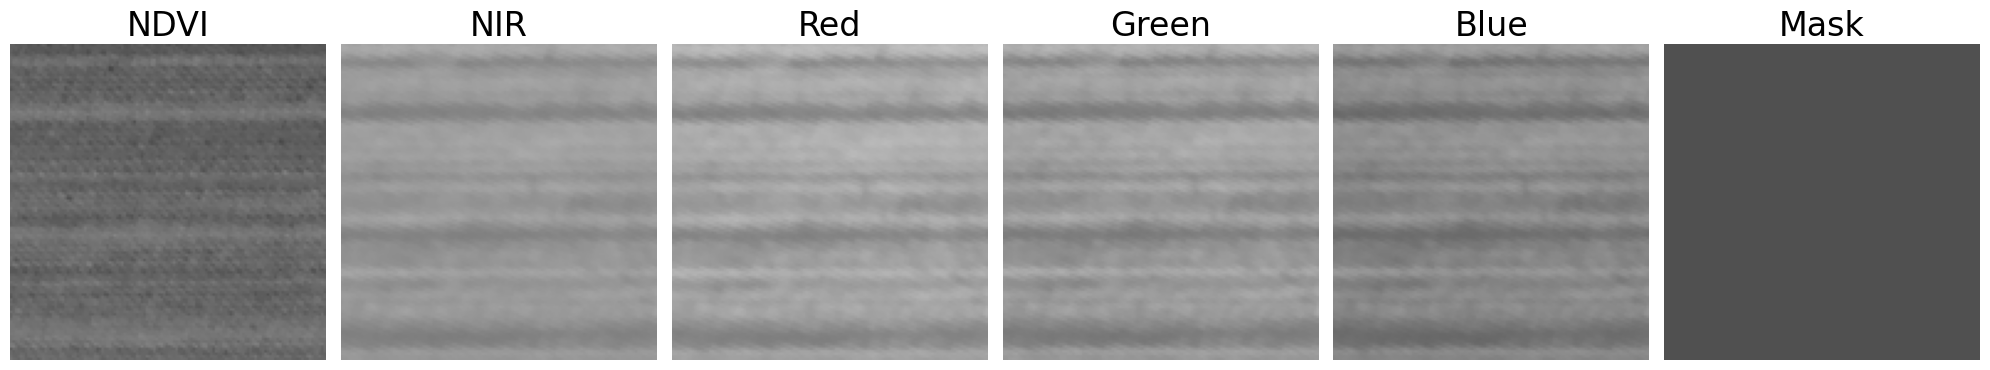

In [7]:
ind = random.randint(0, len(train_images_paths) - 1)
image_path = train_images_paths[ind]
mask_path = train_masks_paths[ind]

channels = {}
for spectrum, path in image_path.items():
  if spectrum == "RGB":
    rgb_image = Image.open(path)
    r, g, b = rgb_image.split()
    channels["Red"] = r
    channels["Green"] = g
    channels["Blue"] = b
  else:
    image = Image.open(path)
    channels[spectrum] = image

mask = Image.open(mask_path).convert("RGB")
num_spectra = len(channels)

fig, axes = plt.subplots(1, num_spectra + 1, figsize=(20, 5))
for i, (spectrum, image) in enumerate(channels.items()):
  axes[i].imshow(image, cmap="gray")
  axes[i].set_title(spectrum, fontsize=24)  # Увеличение размера шрифта
  axes[i].axis("Off")

axes[-1].imshow(mask, cmap="gray")
axes[-1].set_title("Mask", fontsize=24)  # Увеличение размера шрифта
axes[-1].axis("Off")

plt.tight_layout()
plt.show()

**Загрузка изображений в numpy-массивы**

In [8]:
def make_nparrays(images, masks):
    """
    Преобразует списки путей к изображениям и маскам в NumPy-массивы.

    Аргументы:
    images - список словарей, где ключи — спектральные диапазоны ('RGB', 'NDVI' и т. д.),
             а значения — пути к соответствующим изображениям.
    masks - список путей к файлам масок.

    Возвращает:
    X_data - массив изображений (количество каналов зависит от данных)
    y_data - массив сегментационных масок
    """

    X_data = []  # Массив изображений
    y_data = []  # Массив масок

    for image_paths, mask_path in tqdm(zip(images, masks), total=len(masks), desc='Processing data'):

        channels = []

        # Открываем и обрабатываем изображения разных спектров
        for spectrum, path in image_paths.items():
            img = Image.open(path).convert('L')  # Загружаем изображение
            img = np.array(img)  # Нормализуем значения пикселей в диапазон [0, 1]

            # Если канал не RGB, преобразуем его в формат (128, 128, 1), добавляя измерение глубины
            if spectrum != 'RGB':
                img = img.reshape((128, 128, 1))

            channels.append(img)  # Добавляем канал в список

        # Объединяем все спектральные каналы по последней оси (создаем многоканальное изображение)
        image = np.concatenate(channels, axis=-1)

        # Загружаем и обрабатываем маску
        mask = Image.open(mask_path)
        mask = np.array(mask)

        masks = [] # Список для хранения бинарных масок по классам

        # Разделяем маску на 6 классов по пороговым значениям
        for i in [0, 40, 80, 120, 160, 200]:
            cls_mask = (mask == i)  # Создаем бинарную маску для каждого класса
            masks.append(cls_mask)

        # Объединяем все бинарные маски в один массив (кол-во классов, H, W)
        masks = np.stack(masks, axis=0)

        # Преобразуем маску в формат (H, W, 1), где в каждом пикселе записан номер класса
        mask = np.argmax(masks, axis=0)
        mask = np.expand_dims(mask, axis=-1)

        # Добавляем обработанные данные в списки
        X_data.append(image)
        y_data.append(mask)

    # Преобразуем списки в NumPy-массивы
    return np.array(X_data), np.array(y_data, dtype=np.uint8)


In [9]:
train_images, train_masks = make_nparrays(train_images_paths, train_masks_paths)
test_images, test_masks = make_nparrays(test_images_paths, test_masks_paths)
print(f"\nРазмер массива тренировочных изображений: {train_images.shape}\nРазмер массива тренировочных масок: {train_masks.shape}")
print(f"Размер массива тестовых изображений: {test_images.shape}\nРазмер массива тестовых масок: {test_masks.shape}")

Processing data: 100%|██████████| 60/60 [01:22<00:00,  1.38s/it]


Размер массива тренировочных изображений: (60, 128, 128, 5)
Размер массива тренировочных масок: (60, 128, 128, 1)
Размер массива тестовых изображений: (60, 128, 128, 5)
Размер массива тестовых масок: (60, 128, 128, 1)


Размер: (N, H, W, C), где

N - количество изображений,

H x W - размер изображения в пикселах

C - количество каналов (для обычных изображений шесть, три на RGB и по одному для NearIR, NDVI, RedEdge; для масок только один канал с классами)

**Сохранение данных в формате .npz — сжатом формате NumPy, который позволяет хранить несколько массивов в одном файле**

In [ ]:
np.savez_compressed("drive/MyDrive/VKR/dataset/my_dataset/train_images_and_masks.npz", train_images=train_images, train_masks=train_masks)
np.savez_compressed("drive/MyDrive/VKR/dataset/my_dataset/test_images_and_masks.npz", test_images=test_images, test_masks=test_masks)

В дальнейшем мы будем скачивать эти данные с диска таким образом:

In [ ]:
# готовые данные
# import gdown
# train_url = 'https://drive.google.com/uc?id=1EbblX307-OM6ReM_vwMQlxHKG5Y61CVB'
# test_url = 'https://drive.google.com/uc?id=1Rxxi3noANtl05UnXxGYZ_Iaa4Tl9lPCN'
# train_path = "nytrogen-status-analysis/dataset/train_images_and_masks.npz"
# test_path = "nytrogen-status-analysis/dataset/test_images_and_masks.npz"
# gdown.download(train_url, train_path, quiet=False)
# gdown.download(test_url, test_path, quiet=False)
# train_data = np.load(train_path)
# test_data = np.load(test_path)
# train_images = train_data["train_images"]
# train_masks = train_data["train_masks"]
# test_images = test_data["test_images"]
# test_masks = test_data["test_masks"]

In [ ]:
# свои данные
# import gdown
# train_url = 'https://drive.google.com/uc?id=1Z2yXG9L61mxXXBFSIfWbBUew-X2d4xP7'
# test_url = 'https://drive.google.com/uc?id=1x9WCnnOYd_LsuTmMgU1Z2UKri-uV0xuC'
# train_path = "nytrogen-status-analysis/dataset/train_images_and_masks.npz"
# test_path = "nytrogen-status-analysis/dataset/test_images_and_masks.npz"
# gdown.download(train_url, train_path, quiet=False)
# gdown.download(test_url, test_path, quiet=False)
# train_data = np.load(train_path)
# test_data = np.load(test_path)
# train_images = train_data["train_images"]
# train_masks = train_data["train_masks"]
# test_images = test_data["test_images"]
# test_masks = test_data["test_masks"]

**Генерация синтетических данных**

In [ ]:
# Функция для генерации заданного числа синтетических изображений и масок
def generate_synthetic_data(images, masks, N):
    images = images.transpose(0, 3, 1, 2)  # Перестановка каналов
    n, num_channels, h, w = images.shape
    generated_images = []
    generated_masks = []

    for i in range(N):
        base_idx = random.randint(0, n - 1)
        base_image = images[base_idx].copy()
        base_mask = masks[base_idx].copy()
        base_mask = base_mask.squeeze(axis=-1)

        new_img = base_image.copy()
        new_mask = base_mask.copy()

        num_sources = random.randint(1, 6)
        source_inds = np.random.choice([i for i in range(n) if i != base_idx], size=num_sources, replace=False)

        for ind in source_inds:
            img = images[ind]
            mask = masks[ind]
            mask = mask.squeeze(axis=-1)

            spot_mask = np.zeros((h, w), dtype=np.uint8)

            for _ in range(random.randint(3, 8)):  # Количество пятен на изображение
                # Генерация случайного прямоугольника с более равномерным распределением
                rect_w = random.randint(w // 16, w // 4)
                rect_h = random.randint(h // 16, h // 4)

                # Смещение положения в любую часть изображения
                x1 = random.randint(0, w - rect_w)  # Левый верхний угол по ширине
                y1 = random.randint(0, h - rect_h)  # Левый верхний угол по высоте
                x2 = x1 + rect_w
                y2 = y1 + rect_h

                # Добавляем случайные неровности к углам
                shift_range = max(rect_w, rect_h) // 10
                points = np.array([
                    [x1 + random.randint(-shift_range, shift_range), y1 + random.randint(-shift_range, shift_range)],
                    [x2 + random.randint(-shift_range, shift_range), y1 + random.randint(-shift_range, shift_range)],
                    [x2 + random.randint(-shift_range, shift_range), y2 + random.randint(-shift_range, shift_range)],
                    [x1 + random.randint(-shift_range, shift_range), y2 + random.randint(-shift_range, shift_range)]
                ], dtype=np.int32)

                # Рисуем многоугольник
                cv2.fillPoly(spot_mask, [points], 1)

            # Размываем для мягких краев
            spot_mask = cv2.GaussianBlur(spot_mask.astype(np.float32), (11, 11), 3)
            spot_mask = (spot_mask > 0.2).astype(np.uint8)

            # Накладываем прямоугольники на изображение и маску
            for c in range(num_channels):
                new_img[c] = np.where(spot_mask, img[c], new_img[c])
                new_mask = np.where(spot_mask, mask, new_mask)

        generated_images.append(new_img)
        generated_masks.append(new_mask)

    return np.array(generated_images), np.array(generated_masks)

In [ ]:
N = 3000
synth_images, synth_masks = generate_synthetic_data(train_images, train_masks, N)
print(synth_images.shape, synth_masks.shape)

(3000, 5, 128, 128) (3000, 128, 128)


**Демонстрация синтетических изображений и масок**

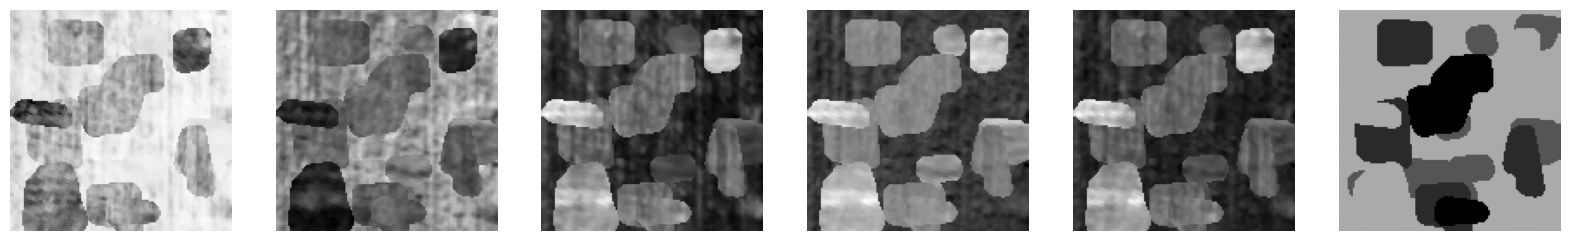

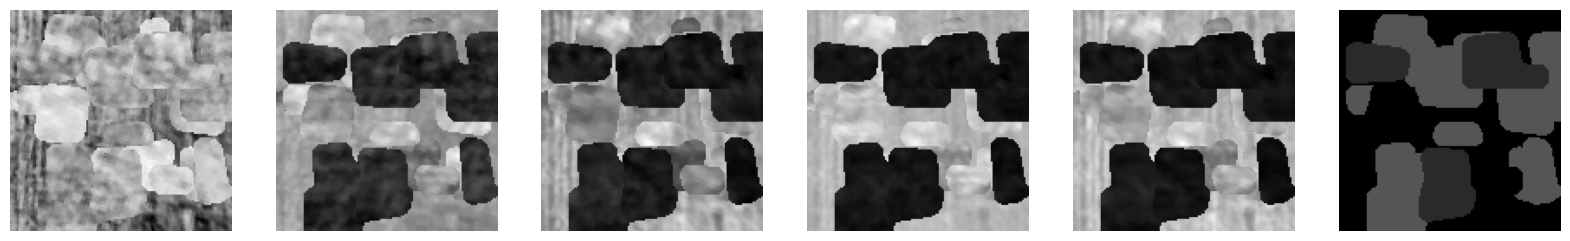

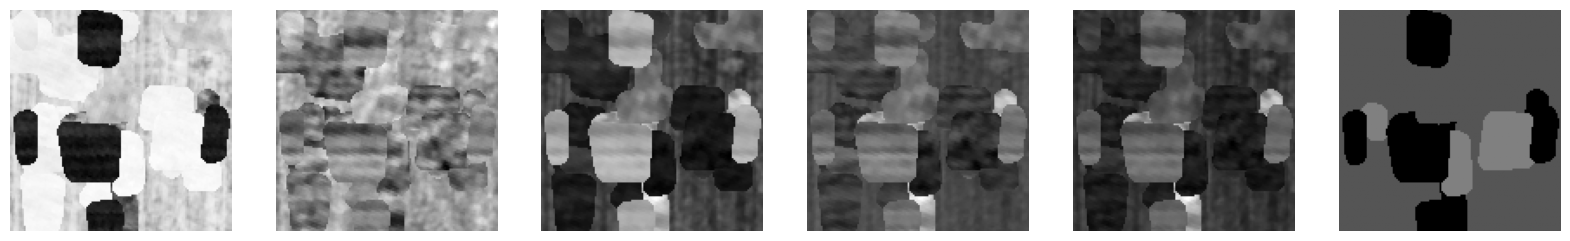

In [ ]:
for i in range(3):
  img = synth_images[i]
  mask = synth_masks[i]
  fig, ax = plt.subplots(1, 6, figsize=(20, 5))
  for i in range(5):
    ax[i].imshow(img[i], cmap='gray')
    ax[i].axis('Off')
  ax[-1].imshow(mask, cmap='gray', vmin=0, vmax=6)
  ax[-1].axis('Off')
  plt.show()

**Для создания сжатых данных преобразуем к нужному формату**

In [ ]:
# Преобразуем синтетические данные к формату (N, 128, 128, 6)
synth_images = np.transpose(synth_images, (0, 2, 3, 1))

# Преобразуем синтетические маски к формату (N, 128, 128, 1)
synth_masks = np.expand_dims(synth_masks, axis=-1)

# Проверяем итоговые размеры
print(f"Размер синтетических изображений: {synth_images.shape}")  # Должно быть (2000, 128, 128, 6)
print(f"Размер синтетических масок: {synth_masks.shape}")  # Должно быть (2000, 128, 128, 1)

Размер синтетических изображений: (3000, 128, 128, 5)
Размер синтетических масок: (3000, 128, 128, 1)


**Сохранение данных в формате .npz**

In [ ]:
np.savez_compressed("drive/MyDrive/VKR/dataset/my_dataset/synth_images_and_masks_another.npz", synth_images=synth_images, synth_masks=synth_masks)

Скачивать синтетические данные с диска можно по такому же принципу:

In [ ]:
# import gdown
# synth_url = 'https://drive.google.com/uc?id=1-7kYbvTdwdjMjO0uDOCY-EIouA0raMBs'
# test_url = 'https://drive.google.com/uc?id=1x9WCnnOYd_LsuTmMgU1Z2UKri-uV0xuC'
# synth_path = "train_images_and_masks.npz"
# test_path = "test_images_and_masks.npz"
# gdown.download(synth_url, synth_path, quiet=False)
# gdown.download(test_url, test_path, quiet=False)
# synth_data = np.load(synth_path)
# test_data = np.load(test_path)
# train_images = synth_data["synth_images"]
# train_masks = synth_data["synth_masks"]
# test_images = test_data["test_images"]
# test_masks = test_data["test_masks"]

**Другой вариант генерации данных**

In [20]:
def generate_synthetic_data(images, masks, N, min_splits=2, max_splits=5):
    """
    Генерирует N синтетических изображений, заменяя части изображения случайными фрагментами из других изображений.

    :param images: numpy массив изображений формы (num_samples, height, width, channels)
    :param masks: numpy массив масок формы (num_samples, height, width, 1)
    :param N: количество синтетических изображений
    :param min_splits: минимальное количество делений по одной оси
    :param max_splits: максимальное количество делений по одной оси
    :return: (синтетические изображения (N, 6, 128, 128), синтетические маски (N, 128, 128))
    """
    num_samples, height, width, channels = images.shape
    generated_images = []
    generated_masks = []

    for _ in range(N):
        base_idx = random.randint(0, num_samples - 1)
        base_image = images[base_idx].copy()
        base_mask = masks[base_idx].copy()

        # Определяем количество разбиений (равномерно делим на сетку)
        num_x_splits = random.randint(min_splits, max_splits)
        num_y_splits = random.randint(min_splits, max_splits)
        step_x = width // num_x_splits
        step_y = height // num_y_splits

        # Проходим по сетке и заменяем участки случайными фрагментами
        for i in range(num_x_splits):
            for j in range(num_y_splits):
                x1, x2 = i * step_x, (i + 1) * step_x
                y1, y2 = j * step_y, (j + 1) * step_y

                # Выбираем случайное изображение (кроме базового)
                random_idx = random.choice([k for k in range(num_samples) if k != base_idx])
                random_patch = images[random_idx, y1:y2, x1:x2, :]
                random_mask_patch = masks[random_idx, y1:y2, x1:x2, :]

                # Заменяем часть изображения и маски
                base_image[y1:y2, x1:x2, :] = random_patch
                base_mask[y1:y2, x1:x2, :] = random_mask_patch

        generated_images.append(base_image)
        generated_masks.append(base_mask.squeeze(-1))  # Убираем последнюю ось маски

    # Приводим изображения к формату (N, 6, 128, 128)
    generated_images = np.array(generated_images).transpose(0, 3, 1, 2)
    generated_masks = np.array(generated_masks)  # Уже в нужном формате (N, 128, 128)

    return generated_images, generated_masks

In [21]:
synthetic_images, synthetic_masks = generate_synthetic_data(train_images, train_masks, N=3000)
print(synthetic_images.shape, synthetic_masks.shape)

(3000, 5, 128, 128) (3000, 128, 128)


**Демонстрация синтетических изображений и масок**

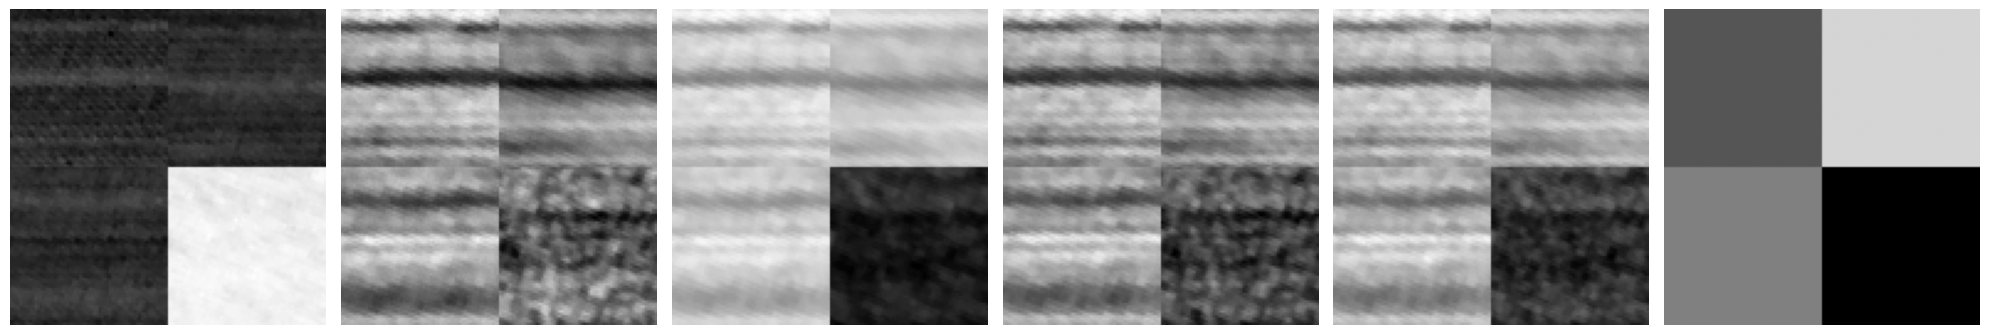

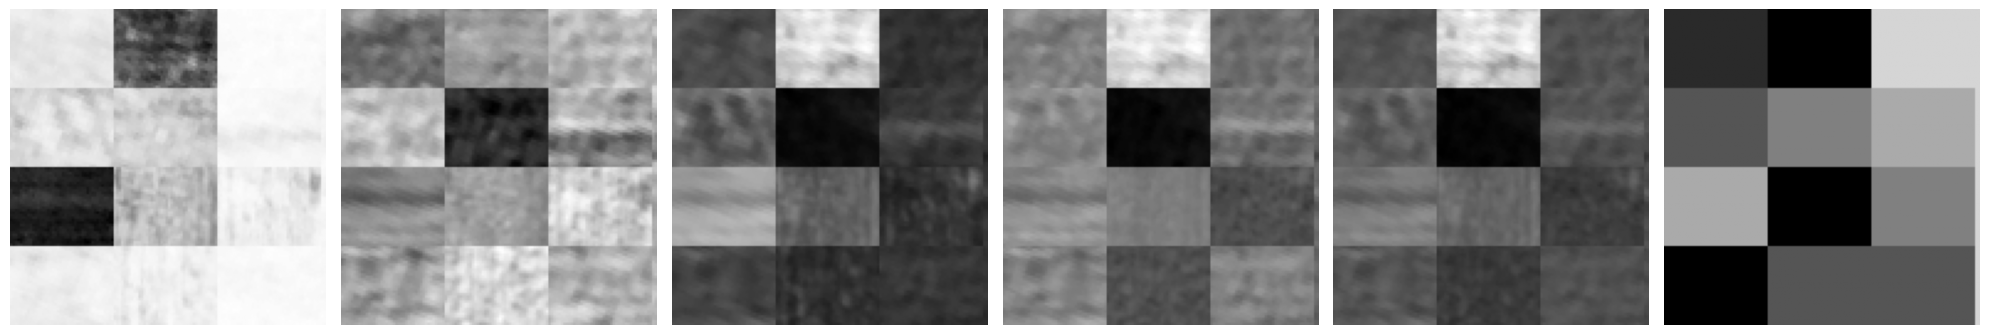

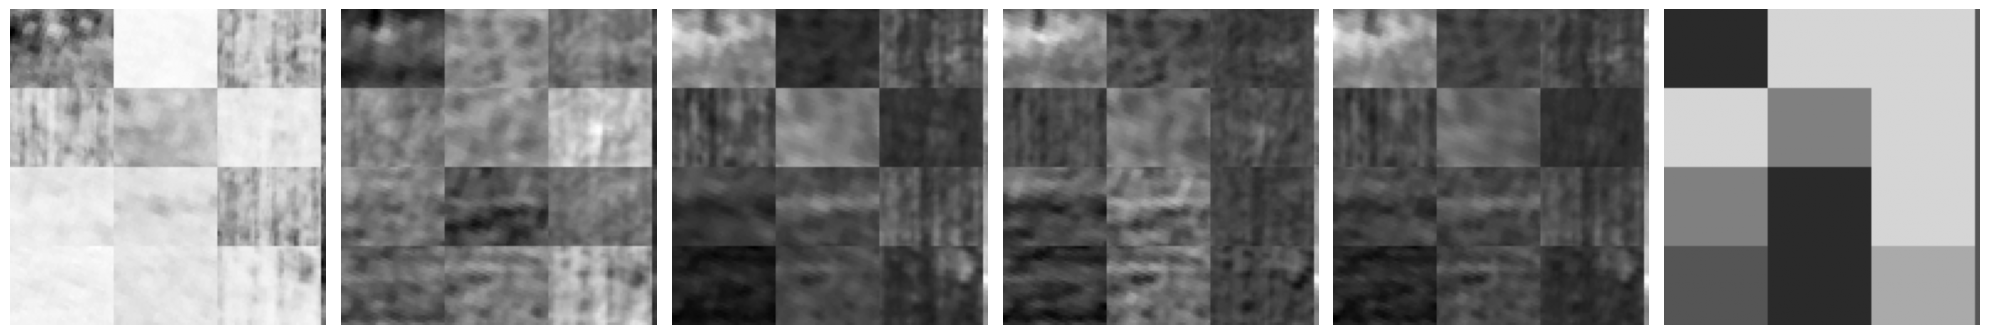

In [27]:
# Выбираем 3 случайных индекса из массива
random_indices = random.sample(range(synthetic_images.shape[0]), 3)

for idx in random_indices:
    img = synthetic_images[idx]
    mask = synthetic_masks[idx]

    fig, ax = plt.subplots(1, 6, figsize=(20, 5))

    for i in range(5):
        channel = img[i]
        # Нормализация: растягиваем в диапазон 0–1 для визуализации
        norm_channel = (channel - channel.min()) / (np.ptp(channel) + 1e-6)
        ax[i].imshow(norm_channel, cmap='gray')
        ax[i].axis('off')

    ax[-1].imshow(mask, cmap='gray', vmin=0, vmax=6)
    ax[-1].axis('off')

    plt.tight_layout()
    plt.show()

**Для создания сжатых данных преобразуем к нужному формату**

In [ ]:
# Преобразуем синтетические данные к формату (N, 128, 128, 6)
synthetic_images = np.transpose(synthetic_images, (0, 2, 3, 1))

# Преобразуем синтетические маски к формату (N, 128, 128, 1)
synthetic_masks = np.expand_dims(synthetic_masks, axis=-1)

# Проверяем итоговые размеры
print(f"Размер синтетических изображений: {synthetic_images.shape}")  # Должно быть (2000, 128, 128, 6)
print(f"Размер синтетических масок: {synthetic_masks.shape}")  # Должно быть (2000, 128, 128, 1)

Размер синтетических изображений: (3000, 128, 128, 5)
Размер синтетических масок: (3000, 128, 128, 1)


**Сохранение данных в формате .npz**

In [ ]:
np.savez_compressed("drive/MyDrive/VKR/dataset/my_dataset/synth_images_and_masks.npz", synth_images=synthetic_images, synth_masks=synthetic_masks)

Скачивать синтетические данные с диска можно по такому же принципу:

In [ ]:
# import gdown
# synth_url = 'https://drive.google.com/uc?id=1-A-G6bKodKNEpro7jUJrusciv8Bz84oo'
# test_url = 'https://drive.google.com/uc?id=1x9WCnnOYd_LsuTmMgU1Z2UKri-uV0xuC'
# synth_path = "train_images_and_masks.npz"
# test_path = "test_images_and_masks.npz"
# gdown.download(synth_url, synth_path, quiet=False)
# gdown.download(test_url, test_path, quiet=False)
# synth_data = np.load(synth_path)
# test_data = np.load(test_path)
# train_images = synth_data["synth_images"]
# train_masks = synth_data["synth_masks"]
# test_images = test_data["test_images"]
# test_masks = test_data["test_masks"]